In [61]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import warnings

warnings.simplefilter('ignore')
%pylab inline

%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
rcParams['figure.figsize'] = 9, 6

import pandas as pd
from scipy import stats
import numpy as np

import seaborn as sns
from sklearn import datasets
from matplotlib import pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

Populating the interactive namespace from numpy and matplotlib


## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [62]:
allData = pd.read_csv('data/Kobe.csv')
pd.set_option('display.max_columns', 1000)

In [63]:
allData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

In [64]:
allData.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [65]:
target = 'shot_made_flag'

In [66]:
data = allData[allData['shot_made_flag'].notnull()].reset_index()

In [67]:
target = data['shot_made_flag']

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25697 entries, 0 to 25696
Data columns (total 26 columns):
index                 25697 non-null int64
action_type           25697 non-null object
combined_shot_type    25697 non-null object
game_event_id         25697 non-null int64
game_id               25697 non-null int64
lat                   25697 non-null float64
loc_x                 25697 non-null int64
loc_y                 25697 non-null int64
lon                   25697 non-null float64
minutes_remaining     25697 non-null int64
period                25697 non-null int64
playoffs              25697 non-null int64
season                25697 non-null object
seconds_remaining     25697 non-null int64
shot_distance         25697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             25697 non-null object
shot_zone_area        25697 non-null object
shot_zone_basic       25697 non-null object
shot_zone_range       25697 non-null object
team_id           

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC

In [69]:
def get_one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [70]:
def plot_vis(df, col, Normalized, kind, width=1, rot=30):
    data_col_1 = data[[col, 'shot_made_flag']][data['shot_made_flag']==1].groupby(col).count()
    data_col_0 = data[[col, 'shot_made_flag']][data['shot_made_flag']==0].groupby(col).count()
    data_merged = pd.merge(data_col_1, data_col_0, left_index=True, right_index=True, suffixes=('=1', '=0'), how='right')
    data_merged_clean = data_merged.fillna(0)
    
    if Normalized==True:
        data_merged_clean['sum'] = data_merged_clean['shot_made_flag=1'] + data_merged_clean['shot_made_flag=0']
        data_merged_clean['shot_made_flag=1_n'] = data_merged_clean['shot_made_flag=1']/data_merged_clean['sum']
        data_merged_clean['shot_made_flag=0_n'] = data_merged_clean['shot_made_flag=0']/data_merged_clean['sum']
        
        if kind=='bar':
            return data_merged_clean[['shot_made_flag=1_n', 'shot_made_flag=0_n']].\
                plot(kind=kind, stacked=True, rot=rot, color=['blue', 'red'], width=width), data_merged_clean
        else:
            return data_merged_clean[['shot_made_flag=1_n', 'shot_made_flag=0_n']].\
                plot(kind=kind, stacked=True, rot=rot, color=['blue', 'red']), data_merged_clean
    else:
        if kind=='bar':
            return data_merged_clean.plot(kind=kind, stacked=True, rot=rot, color=['darkgreen', 'darkred'], width=width), data_merged_clean
        else:
            return data_merged_clean.plot(kind=kind, stacked=True, rot=rot, color=['darkgreen', 'darkred']), data_merged_clean

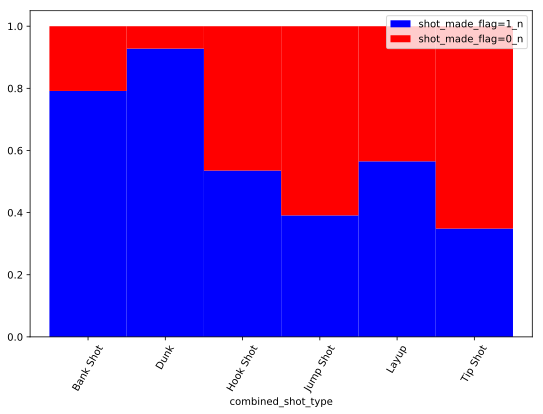

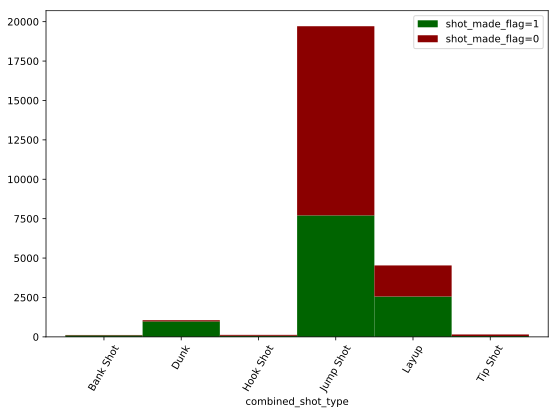

In [71]:
dfs = []
combined_shot_type_df = plot_vis(data, 'combined_shot_type', True, 'bar', width=1, rot=60)
plot_vis(data, 'combined_shot_type', False, 'bar', width=1, rot=60)[0]
dfs.append(combined_shot_type_df)

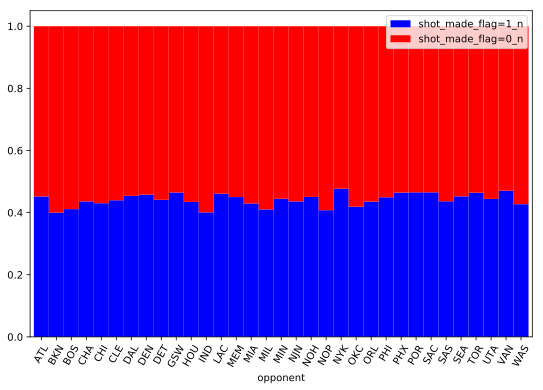

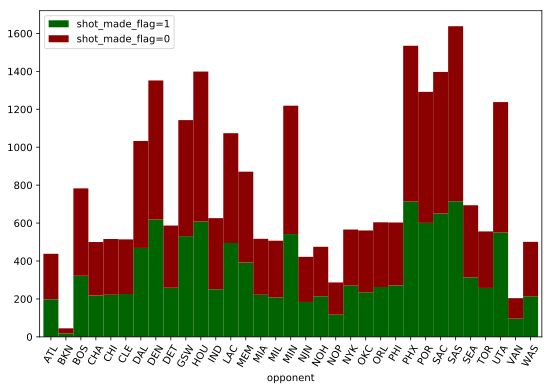

In [72]:
opponent_df = plot_vis(data, 'opponent', True, 'bar', width=1, rot=60)
plot_vis(data, 'opponent', False, 'bar', width=1, rot=60)[0]
dfs.append(opponent_df)

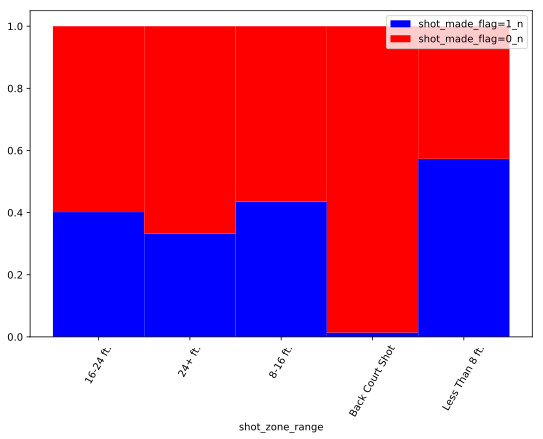

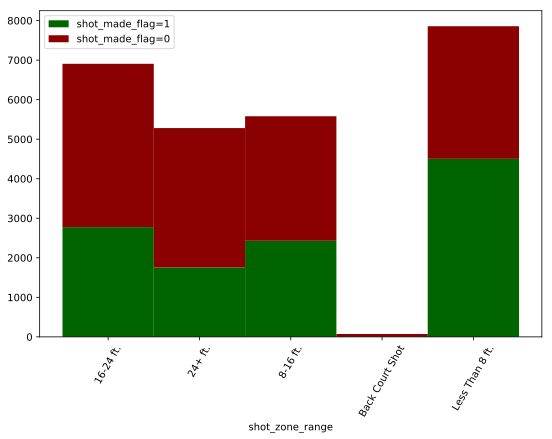

In [73]:
shot_zone_range_df = plot_vis(data, 'shot_zone_range', True, 'bar', width=1, rot=60)
plot_vis(data, 'shot_zone_range', False, 'bar', width=1, rot=60)[0]
dfs.append(shot_zone_range_df)

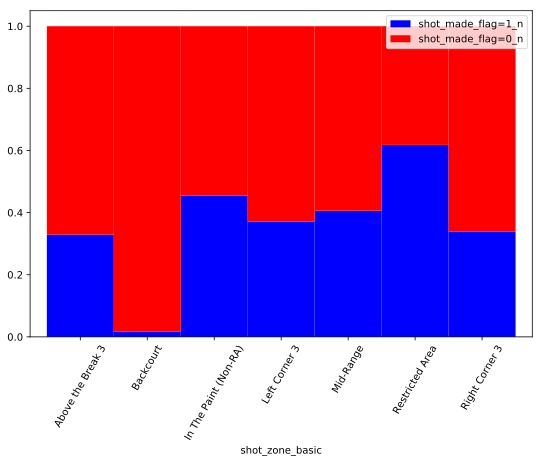

In [74]:
shot_zone_basic_df = plot_vis(data, 'shot_zone_basic', True, 'bar', width=1, rot=60)
dfs.append(shot_zone_basic_df)

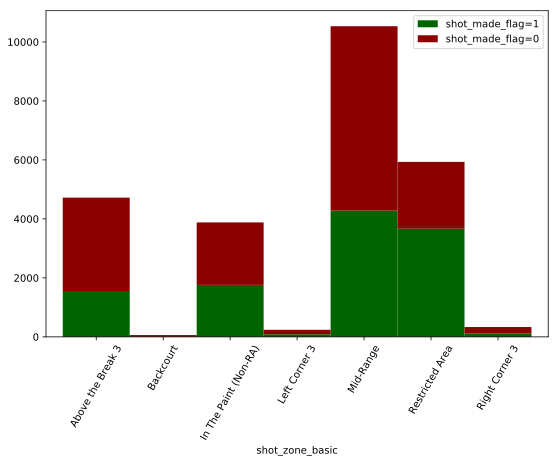

In [75]:
plot_vis(data, 'shot_zone_basic', False, 'bar', width=1, rot=60)[0]

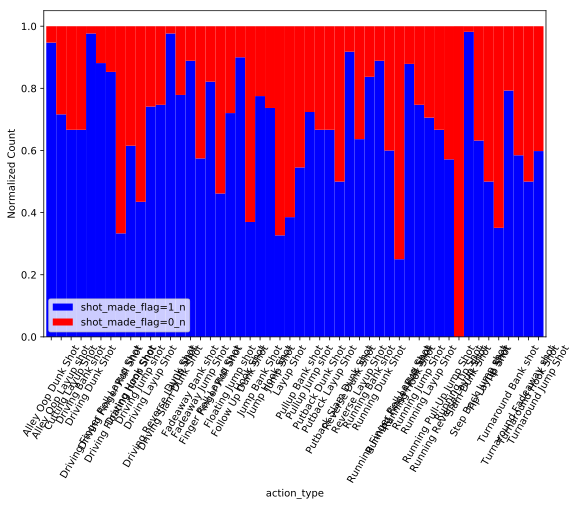

In [76]:
action_type_df = plot_vis(data, 'action_type', True, 'bar', width=1, rot=60)
plt.ylabel('Normalized Count')
dfs.append(action_type_df)

Text(0,0.5,'Normalized Count')

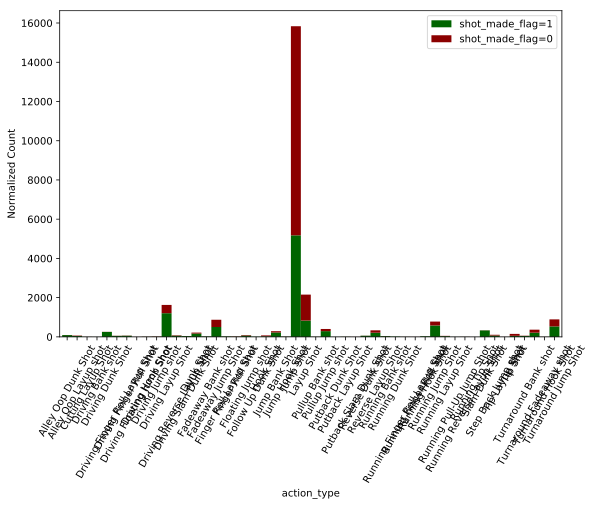

In [77]:
plot_vis(df=data, col='action_type', Normalized=False, kind='bar', rot=60)
plt.ylabel('Normalized Count')

In [78]:
data_action_type = data[['shot_id', 'action_type']].groupby('action_type').count().sort_values('shot_id', ascending=False)

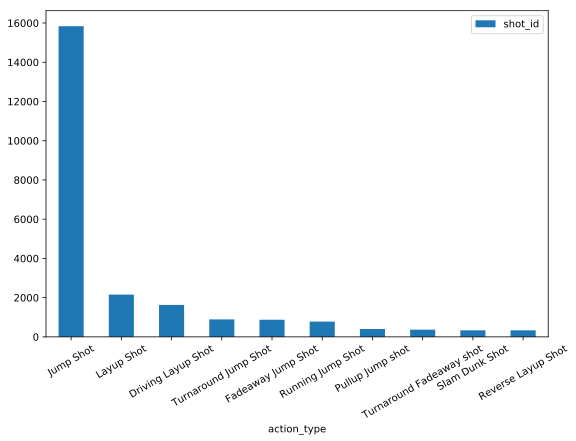

In [79]:
data_action_type[:10].plot(kind='bar', rot=30)

Text(0.5,1,'lat and lon')

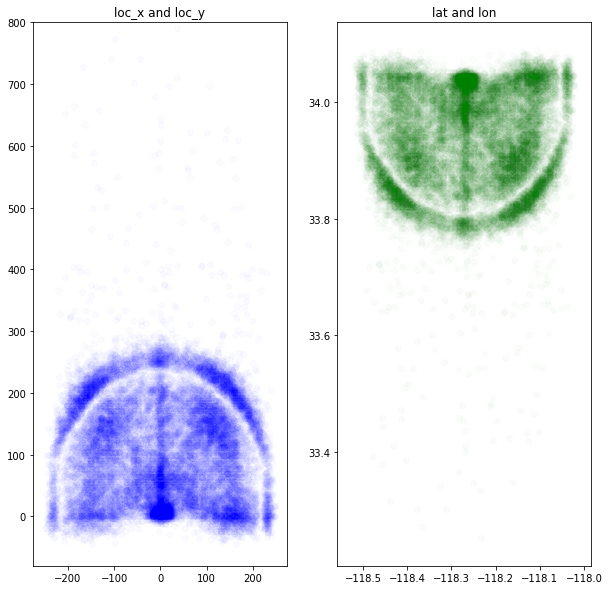

In [80]:
%config InlineBackend.figure_format = 'png' 
alpha = 0.02
plt.figure(figsize=(10,10))

# loc_x and loc_y
plt.subplot(121)
plt.scatter(data.loc_x, data.loc_y, color='blue', alpha=alpha)
plt.title('loc_x and loc_y')
plt.ylim(-80,800)

# lat and lon
plt.subplot(122)
plt.scatter(data.lon, data.lat, color='green', alpha=alpha)
plt.title('lat and lon')

In [81]:
%config InlineBackend.figure_format = 'svg' 

In [82]:
data.columns

Index(['index', 'action_type', 'combined_shot_type', 'game_event_id',
       'game_id', 'lat', 'loc_x', 'loc_y', 'lon', 'minutes_remaining',
       'period', 'playoffs', 'season', 'seconds_remaining', 'shot_distance',
       'shot_made_flag', 'shot_type', 'shot_zone_area', 'shot_zone_basic',
       'shot_zone_range', 'team_id', 'team_name', 'game_date', 'matchup',
       'opponent', 'shot_id'],
      dtype='object')

In [83]:
data.shot_type.unique()

array(['2PT Field Goal', '3PT Field Goal'], dtype=object)

In [84]:
data[['shot_made_flag', 'shot_type']][data['shot_made_flag']==1].groupby('shot_type').count()/data[['shot_made_flag', 'shot_type']].groupby('shot_type').count()

,shot_made_flag
shot_type,
2PT Field Goal,0.477348
3PT Field Goal,0.329268


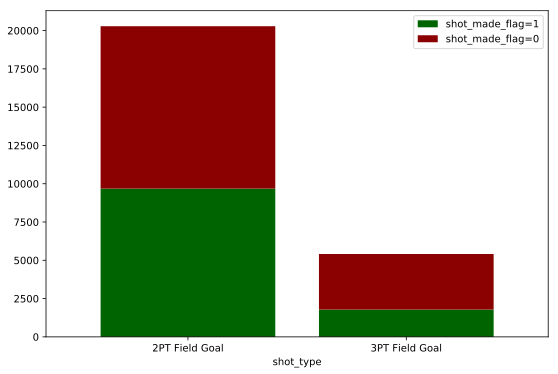

In [85]:
plot_vis(data, 'shot_type', False, 'bar', width=0.8, rot=0)[0]

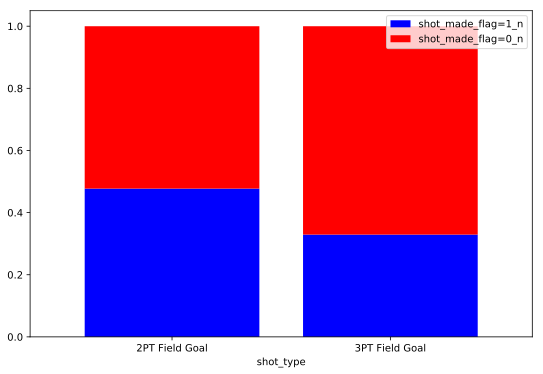

In [86]:
shot_type_df = plot_vis(data, 'shot_type', True, 'bar', width=0.8, rot=0)
dfs.append(shot_type_df)

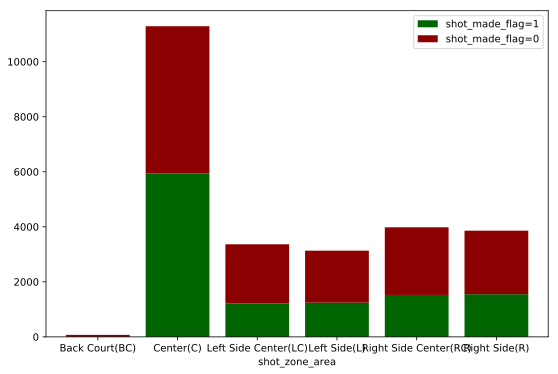

In [87]:
plot_vis(data, 'shot_zone_area', False, 'bar', width=0.8, rot=0)[0]

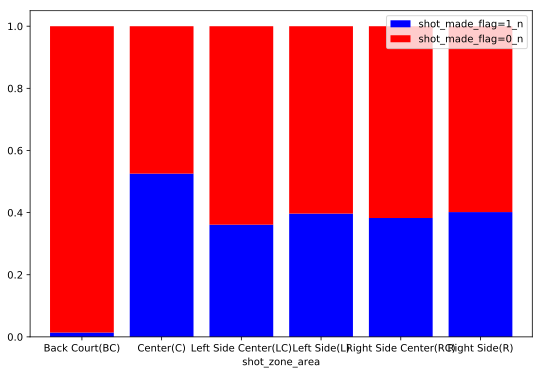

In [88]:
shot_zone_area_df = plot_vis(data, 'shot_zone_area', True, 'bar', width=0.8, rot=0)
dfs.append(shot_zone_area_df)

Text(0.5,1,'shot_zone_range')

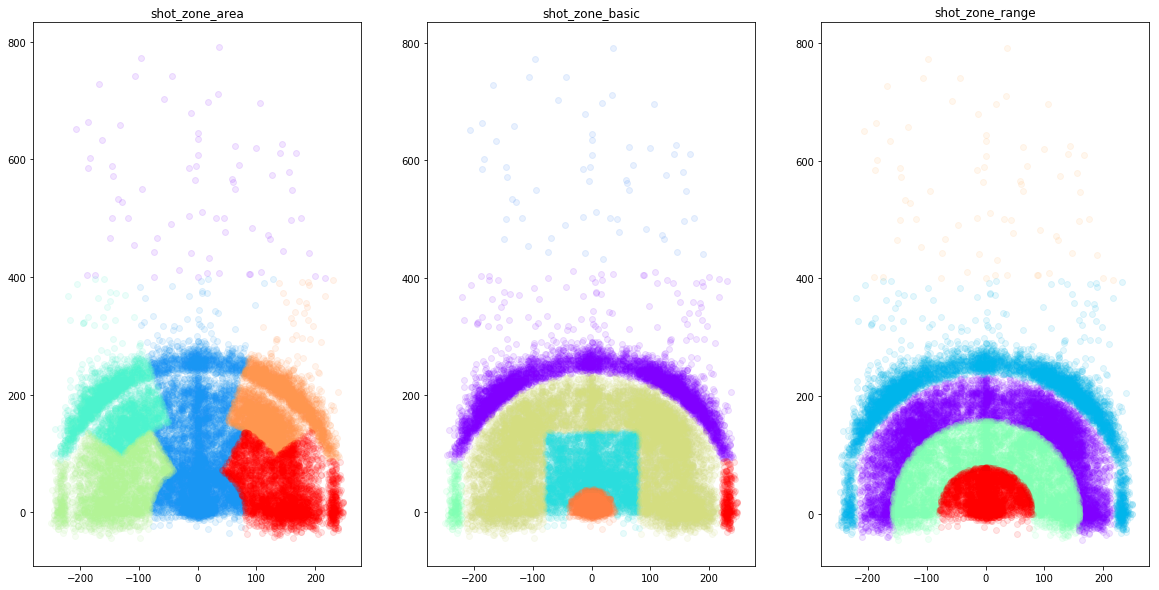

In [89]:
import matplotlib.cm as cm
plt.figure(figsize=(20,10))
%config InlineBackend.figure_format = 'png' 


def scatter_plot_by_category(feat):
    alpha = 0.1
    gs = data.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha)

plt.subplot(131)
scatter_plot_by_category('shot_zone_area')
plt.title('shot_zone_area')

plt.subplot(132)
scatter_plot_by_category('shot_zone_basic')
plt.title('shot_zone_basic')

plt.subplot(133)
scatter_plot_by_category('shot_zone_range')
plt.title('shot_zone_range')

In [90]:
%config InlineBackend.figure_format = 'svg' 

In [91]:
data['time_remaining'] = data.seconds_remaining + data.minutes_remaining*60
data_time_remaining = data[['time_remaining', 'shot_made_flag']].groupby('time_remaining').count()
data_time_remaining = data_time_remaining.rename(columns={'shot_made_flag':'count'})

(0, 100)

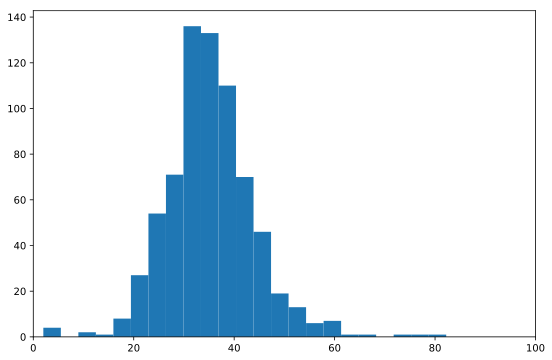

In [92]:
plt.hist(list(data_time_remaining['count']), bins=125)
plt.xlim(0,100)

In [93]:
data_time_remaining = data_time_remaining.reset_index()

In [94]:
x = data_time_remaining['count']

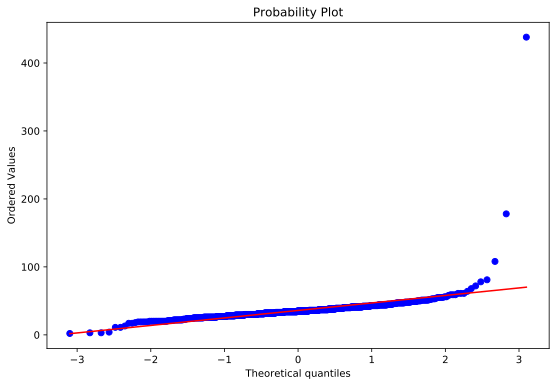

In [95]:
res = stats.probplot(x, plot=plt, dist='norm')

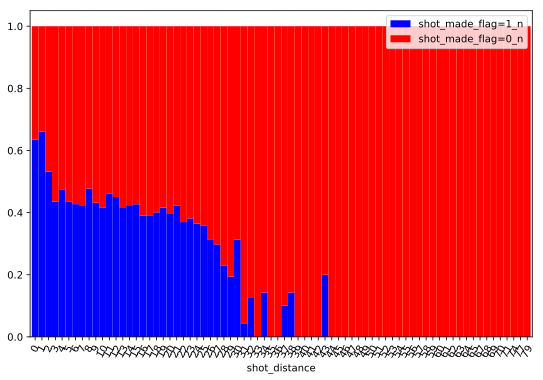

In [96]:
shot_distance_df = plot_vis(data, 'shot_distance', True, 'bar', width=1, rot=60)
dfs.append(shot_zone_area_df)

(0, 40)

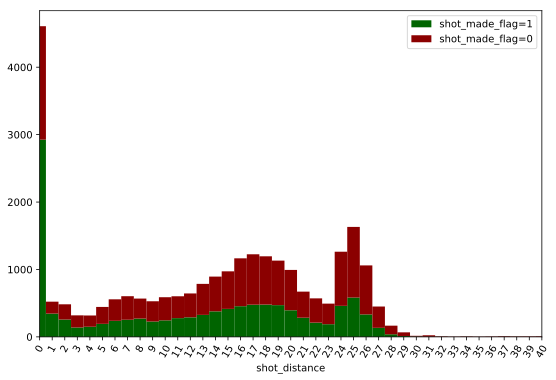

In [97]:
shot_distance_df = plot_vis(data, 'shot_distance', False, 'bar', width=1, rot=60)
plt.xlim(0, 40)

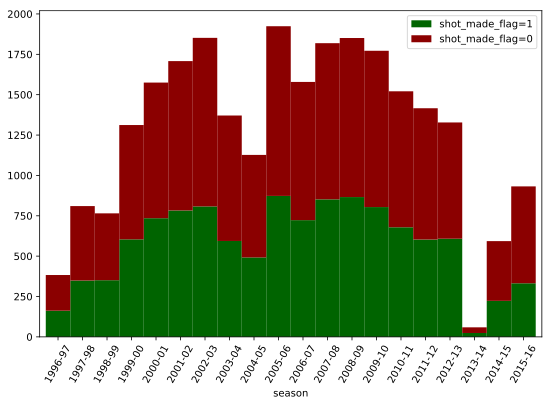

In [98]:
plot_vis(data, 'season', False, 'bar', width=1, rot=60)[0]

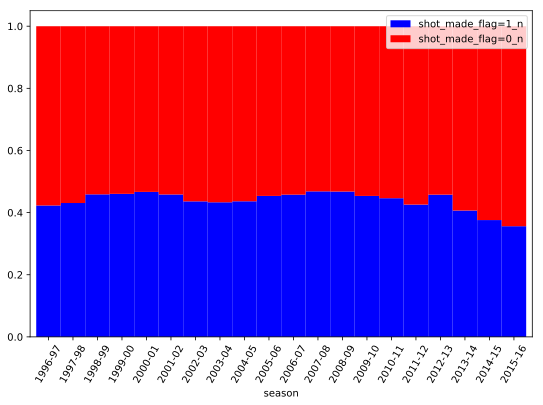

In [99]:
plot_vis(data, 'season', True, 'bar', width=1, rot=60)[0]

In [100]:
data.head()

,index,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id,time_remaining
0,1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2,622
1,2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3,465
2,3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4,412
3,4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5,379
4,5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,0,2000-01,32,14,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6,572


In [101]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['shot_id', col_to_groupby, 'shot_made_flag']].groupby(['shot_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [102]:
dfs = []

action_type_df = get_aggregated_df(data, agg_type='count', col_to_groupby='action_type')
dfs.append(action_type_df)

game_event_id_df = get_aggregated_df(data, agg_type='count', col_to_groupby='game_event_id')
dfs.append(game_event_id_df)

loc_x_df = get_aggregated_df(data, agg_type='count', col_to_groupby='loc_x')
dfs.append(loc_x_df)

loc_y_df = get_aggregated_df(data, agg_type='count', col_to_groupby='loc_y')
dfs.append(loc_y_df)
                             
game_date_df = get_aggregated_df(data, agg_type='count', col_to_groupby='game_date')
dfs.append(game_date_df)

shot_distance_df = get_aggregated_df(data, agg_type='count', col_to_groupby='shot_distance')
dfs.append(shot_distance_df)

combined_shot_type_df = get_aggregated_df(data, agg_type='count', col_to_groupby='combined_shot_type')
dfs.append(combined_shot_type_df)

season_df = get_aggregated_df(data, agg_type='count', col_to_groupby='season')
dfs.append(season_df)

shot_type_df = get_aggregated_df(data, agg_type='count', col_to_groupby='shot_type')
dfs.append(shot_type_df)

shot_zone_area_df = get_aggregated_df(data, agg_type='count', col_to_groupby='shot_zone_area')
dfs.append(shot_zone_area_df)

shot_zone_basic_df = get_aggregated_df(data, agg_type='count', col_to_groupby='shot_zone_basic')
dfs.append(shot_zone_basic_df)

shot_zone_range_df = get_aggregated_df(data, agg_type='count', col_to_groupby='shot_zone_range')
dfs.append(shot_zone_range_df)

opponent_df = get_aggregated_df(data, agg_type='count', col_to_groupby='opponent')
dfs.append(opponent_df)

action_type_df.head()

action_type,action_type_count_Alley Oop Dunk Shot,action_type_count_Alley Oop Layup shot,action_type_count_Cutting Layup Shot,action_type_count_Driving Bank shot,action_type_count_Driving Dunk Shot,action_type_count_Driving Finger Roll Layup Shot,action_type_count_Driving Finger Roll Shot,action_type_count_Driving Floating Bank Jump Shot,action_type_count_Driving Floating Jump Shot,action_type_count_Driving Hook Shot,action_type_count_Driving Jump shot,action_type_count_Driving Layup Shot,action_type_count_Driving Reverse Layup Shot,action_type_count_Driving Slam Dunk Shot,action_type_count_Dunk Shot,action_type_count_Fadeaway Bank shot,action_type_count_Fadeaway Jump Shot,action_type_count_Finger Roll Layup Shot,action_type_count_Finger Roll Shot,action_type_count_Floating Jump shot,action_type_count_Follow Up Dunk Shot,action_type_count_Hook Bank Shot,action_type_count_Hook Shot,action_type_count_Jump Bank Shot,action_type_count_Jump Hook Shot,action_type_count_Jump Shot,action_type_count_Layup Shot,action_type_count_Pullup Bank shot,action_type_count_Pullup Jump shot,action_type_count_Putback Dunk Shot,action_type_count_Putback Layup Shot,action_type_count_Putback Slam Dunk Shot,action_type_count_Reverse Dunk Shot,action_type_count_Reverse Layup Shot,action_type_count_Reverse Slam Dunk Shot,action_type_count_Running Bank shot,action_type_count_Running Dunk Shot,action_type_count_Running Finger Roll Layup Shot,action_type_count_Running Finger Roll Shot,action_type_count_Running Hook Shot,action_type_count_Running Jump Shot,action_type_count_Running Layup Shot,action_type_count_Running Pull-Up Jump Shot,action_type_count_Running Reverse Layup Shot,action_type_count_Running Slam Dunk Shot,action_type_count_Running Tip Shot,action_type_count_Slam Dunk Shot,action_type_count_Step Back Jump shot,action_type_count_Tip Layup Shot,action_type_count_Tip Shot,action_type_count_Turnaround Bank shot,action_type_count_Turnaround Fadeaway shot,action_type_count_Turnaround Finger Roll Shot,action_type_count_Turnaround Hook Shot,action_type_count_Turnaround Jump Shot
shot_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [103]:
data = data.set_index('shot_id')

In [104]:
for df in dfs:
    print(df.shape)

(25697, 55)
(25697, 618)
(25697, 486)
(25697, 446)
(25697, 1558)
(25697, 74)
(25697, 6)
(25697, 20)
(25697, 2)
(25697, 6)
(25697, 7)
(25697, 5)
(25697, 33)


In [105]:
for df in dfs:
    train_df = pd.merge(data, df, left_index=True, right_index=True, how='inner')
    data = train_df

In [106]:
train_df.shape

(25697, 3342)

In [107]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 2 to 30697
Columns: 3342 entries, index to opponent_count_WAS
dtypes: float64(3), int64(3328), object(11)
memory usage: 656.7+ MB



**Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.**

In [108]:
# # train_df = pd.merge(data, action_type_df[1].reset_index(), on='action_type')
# # for df in dfs:
# #     train_df = pd.merge(train_df, df[1].reset_index(), on=df[1].index.name)
# for df in dfs:
#     df_goh = get_one_hot(df[1].reset_index(), [df[1].index.name])
#     train_df = pd.merge(data, df_goh, on=df_goh.columns[0])
#     data = train_df
# train_df = train_df.drop(['action_type', 'combined_shot_type', 'season', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'team_name', 'game_date', 'matchup', 'opponent'], axis=1)
# columns = pd.io.parsers.ParserBase({'names':train_df.columns})._maybe_dedup_names(train_df.columns)
# train_df.columns = columns

In [109]:
train_df = train_df.drop(train_df.columns[:25], axis=1)

In [110]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 2 to 30697
Columns: 3317 entries, time_remaining to opponent_count_WAS
dtypes: int64(3317)
memory usage: 651.8 MB


In [111]:
from sklearn.metrics import roc_auc_score, roc_curve
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost
from sklearn.linear_model import LogisticRegression

In [112]:
clf = LogisticRegression()
X_train = train_df#.drop(['target_flag'], axis=1)
y_train = target

In [113]:
clf.fit(X=X_train, y=y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [114]:
# xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
# # xgb = DecisionTreeClassifier()
# xgb.fit(X_train, y_train)
# y_train_predict = xgb.predict_proba(X_train)[:, 1]
# roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
# print("Train: ", roc_auc_train)

In [115]:
# import matplotlib
# fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)

# plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
# plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('XGB Classifier', size=16)
# plt.legend(loc='lower right')
# plt.show()

In [116]:
y_train_predict = clf.predict_proba(X_train)[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 9)
print("Train: ", round(roc_auc_train, 2))

Train:  0.79


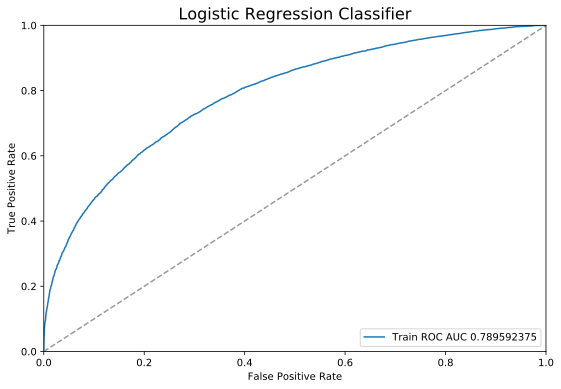

In [117]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)

plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Classifier', size=16)
plt.legend(loc='lower right')
plt.show()